# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 pre-selected sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'               # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11833
EM converged at iteration 19, llf=-11673, convergence criterion=9.8128e-07 < tolerance=1e-06
EM start iterations, llf=-11845
EM converged at iteration 20, llf=-11685, convergence criterion=7.9017e-07 < tolerance=1e-06
EM start iterations, llf=-11902
EM converged at iteration 20, llf=-11739, convergence criterion=8.5868e-07 < tolerance=1e-06
EM start iterations, llf=-11909
EM converged at iteration 20, llf=-11746, convergence criterion=8.487e-07 < tolerance=1e-06
EM start iterations, llf=-11976
EM converged at iteration 21, llf=-11812, convergence criterion=8.5094e-07 < tolerance=1e-06
EM start iterations, llf=-11984
EM converged at iteration 21, llf=-11821, convergence criterion=8.6568e-07 < tolerance=1e-06
EM start iterations, llf=-12041
EM converged at iteration 20, llf=-11881, convergence criterion=7.9454e-07 < tolerance=1e-06
EM start iterations, llf=-12041
EM converged at iteration 20, llf=-11881, convergence criterion=7.9454e-07 < tolerance=1e-06
E

EM start iterations, llf=-13346
EM converged at iteration 15, llf=-13212, convergence criterion=9.4087e-07 < tolerance=1e-06
EM start iterations, llf=-13397
EM converged at iteration 15, llf=-13264, convergence criterion=9.8574e-07 < tolerance=1e-06
EM start iterations, llf=-13407
EM converged at iteration 16, llf=-13275, convergence criterion=8.8336e-07 < tolerance=1e-06
EM start iterations, llf=-13459
EM converged at iteration 15, llf=-13323, convergence criterion=9.9228e-07 < tolerance=1e-06
EM start iterations, llf=-13459
EM converged at iteration 15, llf=-13323, convergence criterion=9.9228e-07 < tolerance=1e-06
EM start iterations, llf=-13468
EM converged at iteration 16, llf=-13333, convergence criterion=9.1737e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM converged at iteration 16, llf=-13378, convergence criterion=9.2776e-07 < tolerance=1e-06
EM start iterations, llf=-13521
EM converged at iteration 16, llf=-13384, convergence criterion=9.2376e-07 < tolerance=1e-06


EM start iterations, llf=-15035
EM converged at iteration 15, llf=-14887, convergence criterion=8.761e-07 < tolerance=1e-06
EM start iterations, llf=-15035
EM converged at iteration 15, llf=-14887, convergence criterion=8.761e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM converged at iteration 15, llf=-14897, convergence criterion=8.7207e-07 < tolerance=1e-06
EM start iterations, llf=-15097
EM converged at iteration 15, llf=-14950, convergence criterion=8.8603e-07 < tolerance=1e-06
EM start iterations, llf=-15108
EM converged at iteration 15, llf=-14961, convergence criterion=8.7272e-07 < tolerance=1e-06
EM start iterations, llf=-15156
EM converged at iteration 14, llf=-15009, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-15164
EM converged at iteration 14, llf=-15017, convergence criterion=9.7872e-07 < tolerance=1e-06
EM start iterations, llf=-15211
EM converged at iteration 14, llf=-15064, convergence criterion=9.7782e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16783
EM converged at iteration 14, llf=-16625, convergence criterion=9.251e-07 < tolerance=1e-06
EM start iterations, llf=-16787
EM converged at iteration 14, llf=-16629, convergence criterion=9.318e-07 < tolerance=1e-06
EM start iterations, llf=-16841
EM converged at iteration 14, llf=-16683, convergence criterion=9.3118e-07 < tolerance=1e-06
EM start iterations, llf=-16849
EM converged at iteration 14, llf=-16691, convergence criterion=9.3116e-07 < tolerance=1e-06
EM start iterations, llf=-16904
EM converged at iteration 14, llf=-16746, convergence criterion=9.3734e-07 < tolerance=1e-06
EM start iterations, llf=-16904
EM converged at iteration 14, llf=-16746, convergence criterion=9.3734e-07 < tolerance=1e-06
EM start iterations, llf=-16912
EM converged at iteration 14, llf=-16752, convergence criterion=9.3131e-07 < tolerance=1e-06
EM start iterations, llf=-16965
EM converged at iteration 14, llf=-16805, convergence criterion=9.1564e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18320
EM converged at iteration 13, llf=-18158, convergence criterion=9.5043e-07 < tolerance=1e-06
EM start iterations, llf=-18379
EM converged at iteration 13, llf=-18216, convergence criterion=9.2117e-07 < tolerance=1e-06
EM start iterations, llf=-18379
EM converged at iteration 13, llf=-18216, convergence criterion=9.2117e-07 < tolerance=1e-06
EM start iterations, llf=-18384
EM converged at iteration 13, llf=-18221, convergence criterion=9.2336e-07 < tolerance=1e-06
EM start iterations, llf=-18435
EM converged at iteration 13, llf=-18272, convergence criterion=9.3712e-07 < tolerance=1e-06
EM start iterations, llf=-18442
EM converged at iteration 13, llf=-18279, convergence criterion=9.3632e-07 < tolerance=1e-06
EM start iterations, llf=-18499
EM converged at iteration 13, llf=-18335, convergence criterion=9.23e-07 < tolerance=1e-06
EM start iterations, llf=-18506
EM converged at iteration 13, llf=-18342, convergence criterion=9.2455e-07 < tolerance=1e-06
EM

EM converged at iteration 26, llf=-12218, convergence criterion=9.4976e-07 < tolerance=1e-06
EM start iterations, llf=-12400
EM converged at iteration 27, llf=-12212, convergence criterion=9.488e-07 < tolerance=1e-06
EM start iterations, llf=-12460
EM converged at iteration 19, llf=-12301, convergence criterion=9.1024e-07 < tolerance=1e-06
EM start iterations, llf=-12468
EM converged at iteration 16, llf=-12319, convergence criterion=8.8785e-07 < tolerance=1e-06
EM start iterations, llf=-12441
EM converged at iteration 15, llf=-12300, convergence criterion=8.9741e-07 < tolerance=1e-06
EM start iterations, llf=-12442
EM converged at iteration 14, llf=-12303, convergence criterion=9.4625e-07 < tolerance=1e-06
EM start iterations, llf=-12432
EM converged at iteration 14, llf=-12298, convergence criterion=9.5687e-07 < tolerance=1e-06
EM start iterations, llf=-12432
EM converged at iteration 14, llf=-12298, convergence criterion=9.5687e-07 < tolerance=1e-06
EM start iterations, llf=-12425
E

EM start iterations, llf=-13846
EM converged at iteration 15, llf=-13712, convergence criterion=8.7069e-07 < tolerance=1e-06
EM start iterations, llf=-13873
EM converged at iteration 15, llf=-13742, convergence criterion=8.6153e-07 < tolerance=1e-06
EM start iterations, llf=-13877
EM converged at iteration 15, llf=-13744, convergence criterion=8.8672e-07 < tolerance=1e-06
EM start iterations, llf=-13924
EM converged at iteration 15, llf=-13786, convergence criterion=8.947e-07 < tolerance=1e-06
EM start iterations, llf=-13924
EM converged at iteration 15, llf=-13786, convergence criterion=8.947e-07 < tolerance=1e-06
EM start iterations, llf=-13933
EM converged at iteration 15, llf=-13797, convergence criterion=8.8664e-07 < tolerance=1e-06
EM start iterations, llf=-13987
EM converged at iteration 15, llf=-13850, convergence criterion=8.6756e-07 < tolerance=1e-06
EM start iterations, llf=-13995
EM converged at iteration 15, llf=-13858, convergence criterion=8.6438e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15610
EM converged at iteration 15, llf=-15457, convergence criterion=8.6747e-07 < tolerance=1e-06
EM start iterations, llf=-15610
EM converged at iteration 15, llf=-15457, convergence criterion=8.6747e-07 < tolerance=1e-06
EM start iterations, llf=-15620
EM converged at iteration 15, llf=-15467, convergence criterion=8.8455e-07 < tolerance=1e-06
EM start iterations, llf=-15673
EM converged at iteration 14, llf=-15521, convergence criterion=9.9755e-07 < tolerance=1e-06
EM start iterations, llf=-15676
EM converged at iteration 15, llf=-15524, convergence criterion=8.8439e-07 < tolerance=1e-06
EM start iterations, llf=-15735
EM converged at iteration 15, llf=-15583, convergence criterion=8.8486e-07 < tolerance=1e-06
EM start iterations, llf=-15740
EM converged at iteration 15, llf=-15587, convergence criterion=8.8636e-07 < tolerance=1e-06
EM start iterations, llf=-15783
EM converged at iteration 15, llf=-15630, convergence criterion=8.9422e-07 < tolerance=1e-06


EM start iterations, llf=-17337
EM converged at iteration 14, llf=-17175, convergence criterion=9.799e-07 < tolerance=1e-06
EM start iterations, llf=-17342
EM converged at iteration 14, llf=-17180, convergence criterion=9.7493e-07 < tolerance=1e-06
EM start iterations, llf=-17397
EM converged at iteration 14, llf=-17235, convergence criterion=9.7924e-07 < tolerance=1e-06
EM start iterations, llf=-17406
EM converged at iteration 14, llf=-17243, convergence criterion=9.8161e-07 < tolerance=1e-06
EM start iterations, llf=-17454
EM converged at iteration 14, llf=-17291, convergence criterion=9.7457e-07 < tolerance=1e-06
EM start iterations, llf=-17454
EM converged at iteration 14, llf=-17291, convergence criterion=9.7457e-07 < tolerance=1e-06
EM start iterations, llf=-17473
EM converged at iteration 14, llf=-17311, convergence criterion=9.7287e-07 < tolerance=1e-06
EM start iterations, llf=-17528
EM converged at iteration 14, llf=-17365, convergence criterion=9.6553e-07 < tolerance=1e-06
E

EM start iterations, llf=-18865
EM converged at iteration 14, llf=-18698, convergence criterion=8.6118e-07 < tolerance=1e-06
EM start iterations, llf=-18916
EM converged at iteration 14, llf=-18748, convergence criterion=8.6708e-07 < tolerance=1e-06
EM start iterations, llf=-18916
EM converged at iteration 14, llf=-18748, convergence criterion=8.6708e-07 < tolerance=1e-06
EM start iterations, llf=-18924
EM converged at iteration 14, llf=-18756, convergence criterion=8.63e-07 < tolerance=1e-06
EM start iterations, llf=-18979
EM converged at iteration 13, llf=-18810, convergence criterion=9.9821e-07 < tolerance=1e-06
EM start iterations, llf=-18987
EM converged at iteration 14, llf=-18818, convergence criterion=8.5883e-07 < tolerance=1e-06
EM start iterations, llf=-19039
EM converged at iteration 14, llf=-18870, convergence criterion=8.5882e-07 < tolerance=1e-06
EM start iterations, llf=-19048
EM converged at iteration 14, llf=-18880, convergence criterion=8.5807e-07 < tolerance=1e-06
EM

EM converged at iteration 35, llf=-12530, convergence criterion=9.9984e-07 < tolerance=1e-06
EM start iterations, llf=-12672
EM converged at iteration 33, llf=-12542, convergence criterion=9.9799e-07 < tolerance=1e-06
EM start iterations, llf=-12723
EM converged at iteration 28, llf=-12594, convergence criterion=9.9395e-07 < tolerance=1e-06
EM start iterations, llf=-12735
EM converged at iteration 23, llf=-12604, convergence criterion=9.8547e-07 < tolerance=1e-06
EM start iterations, llf=-12786
EM converged at iteration 33, llf=-12658, convergence criterion=9.9986e-07 < tolerance=1e-06
EM start iterations, llf=-12797
EM converged at iteration 29, llf=-12669, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-12858
EM converged at iteration 19, llf=-12729, convergence criterion=9.6727e-07 < tolerance=1e-06
EM start iterations, llf=-12858
EM converged at iteration 19, llf=-12729, convergence criterion=9.6727e-07 < tolerance=1e-06
EM start iterations, llf=-12866


EM start iterations, llf=-14367
EM converged at iteration 19, llf=-14225, convergence criterion=9.324e-07 < tolerance=1e-06
EM start iterations, llf=-14417
EM converged at iteration 18, llf=-14275, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-14428
EM converged at iteration 19, llf=-14286, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-14480
EM converged at iteration 19, llf=-14337, convergence criterion=9.337e-07 < tolerance=1e-06
EM start iterations, llf=-14480
EM converged at iteration 19, llf=-14337, convergence criterion=9.337e-07 < tolerance=1e-06
EM start iterations, llf=-14489
EM converged at iteration 18, llf=-14346, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-14543
EM converged at iteration 18, llf=-14401, convergence criterion=9.4169e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 18, llf=-14410, convergence criterion=9.701e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-16158
EM converged at iteration 22, llf=-16008, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-16158
EM converged at iteration 22, llf=-16008, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-16168
EM converged at iteration 22, llf=-16018, convergence criterion=9.8039e-07 < tolerance=1e-06
EM start iterations, llf=-16222
EM converged at iteration 22, llf=-16072, convergence criterion=9.7205e-07 < tolerance=1e-06
EM start iterations, llf=-16231
EM converged at iteration 22, llf=-16081, convergence criterion=9.5946e-07 < tolerance=1e-06
EM start iterations, llf=-16283
EM converged at iteration 22, llf=-16132, convergence criterion=9.6176e-07 < tolerance=1e-06
EM start iterations, llf=-16291
EM converged at iteration 22, llf=-16141, convergence criterion=9.6083e-07 < tolerance=1e-06
EM start iterations, llf=-16346
EM converged at iteration 22, llf=-16196, convergence criterion=9.6214e-07 < tolerance=1e-06


EM start iterations, llf=-17890
EM converged at iteration 22, llf=-17730, convergence criterion=9.5486e-07 < tolerance=1e-06
EM start iterations, llf=-17895
EM converged at iteration 22, llf=-17735, convergence criterion=9.597e-07 < tolerance=1e-06
EM start iterations, llf=-17947
EM converged at iteration 22, llf=-17786, convergence criterion=9.615e-07 < tolerance=1e-06
EM start iterations, llf=-17954
EM converged at iteration 22, llf=-17793, convergence criterion=9.6217e-07 < tolerance=1e-06
EM start iterations, llf=-18009
EM converged at iteration 22, llf=-17848, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-18009
EM converged at iteration 22, llf=-17848, convergence criterion=9.8684e-07 < tolerance=1e-06
EM start iterations, llf=-18016
EM converged at iteration 22, llf=-17855, convergence criterion=9.8638e-07 < tolerance=1e-06
EM start iterations, llf=-18070
EM converged at iteration 22, llf=-17909, convergence criterion=9.8942e-07 < tolerance=1e-06
EM

EM start iterations, llf=-19139
EM converged at iteration 20, llf=-18977, convergence criterion=9.6553e-07 < tolerance=1e-06
EM start iterations, llf=-19191
EM converged at iteration 20, llf=-19028, convergence criterion=9.7113e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 0:45:53.682195.
EM start iterations, llf=-11331
EM converged at iteration 29, llf=-11197, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-11342
EM converged at iteration 29, llf=-11209, convergence criterion=9.7507e-07 < tolerance=1e-06
EM start iterations, llf=-11391
EM converged at iteration 28, llf=-11258, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-11399
EM converged at iteration 29, llf=-11265, convergence criterion=9.3604e-07 < tolerance=1e-06
EM start iterations, llf=-11454
EM converged at iteration 26, llf=-11322, convergence criterion=9.9346e-07 < tolerance=1e-06
EM start iterations, llf=-11460
EM converged at iter

EM start iterations, llf=-12697
EM converged at iteration 31, llf=-12548, convergence criterion=9.3714e-07 < tolerance=1e-06
EM start iterations, llf=-12705
EM converged at iteration 31, llf=-12556, convergence criterion=9.3428e-07 < tolerance=1e-06
EM start iterations, llf=-12750
EM converged at iteration 30, llf=-12598, convergence criterion=9.7564e-07 < tolerance=1e-06
EM start iterations, llf=-12758
EM converged at iteration 30, llf=-12604, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-12782
EM converged at iteration 30, llf=-12629, convergence criterion=9.5927e-07 < tolerance=1e-06
EM start iterations, llf=-12802
EM converged at iteration 30, llf=-12647, convergence criterion=9.7818e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM converged at iteration 30, llf=-12693, convergence criterion=9.454e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM converged at iteration 30, llf=-12693, convergence criterion=9.454e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14255
EM converged at iteration 27, llf=-14080, convergence criterion=9.3313e-07 < tolerance=1e-06
EM start iterations, llf=-14305
EM converged at iteration 27, llf=-14131, convergence criterion=9.176e-07 < tolerance=1e-06
EM start iterations, llf=-14314
EM converged at iteration 27, llf=-14139, convergence criterion=9.2179e-07 < tolerance=1e-06
EM start iterations, llf=-14368
EM converged at iteration 26, llf=-14196, convergence criterion=9.4286e-07 < tolerance=1e-06
EM start iterations, llf=-14368
EM converged at iteration 26, llf=-14196, convergence criterion=9.4286e-07 < tolerance=1e-06
EM start iterations, llf=-14377
EM converged at iteration 26, llf=-14205, convergence criterion=9.3855e-07 < tolerance=1e-06
EM start iterations, llf=-14427
EM converged at iteration 26, llf=-14255, convergence criterion=9.2935e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM converged at iteration 26, llf=-14265, convergence criterion=9.2233e-07 < tolerance=1e-06
E

EM start iterations, llf=-15976
EM converged at iteration 25, llf=-15794, convergence criterion=9.3596e-07 < tolerance=1e-06
EM start iterations, llf=-15976
EM converged at iteration 25, llf=-15794, convergence criterion=9.3596e-07 < tolerance=1e-06
EM start iterations, llf=-15989
EM converged at iteration 25, llf=-15807, convergence criterion=9.3514e-07 < tolerance=1e-06
EM start iterations, llf=-16046
EM converged at iteration 25, llf=-15865, convergence criterion=9.392e-07 < tolerance=1e-06
EM start iterations, llf=-16051
EM converged at iteration 25, llf=-15869, convergence criterion=9.4093e-07 < tolerance=1e-06
EM start iterations, llf=-16103
EM converged at iteration 25, llf=-15922, convergence criterion=9.3503e-07 < tolerance=1e-06
EM start iterations, llf=-16110
EM converged at iteration 25, llf=-15929, convergence criterion=9.3249e-07 < tolerance=1e-06
EM start iterations, llf=-16164
EM converged at iteration 25, llf=-15983, convergence criterion=9.3994e-07 < tolerance=1e-06
E

EM start iterations, llf=-17446
EM converged at iteration 24, llf=-17269, convergence criterion=9.3299e-07 < tolerance=1e-06
EM start iterations, llf=-17457
EM converged at iteration 24, llf=-17281, convergence criterion=9.254e-07 < tolerance=1e-06
EM start iterations, llf=-17513
EM converged at iteration 23, llf=-17336, convergence criterion=9.974e-07 < tolerance=1e-06
EM start iterations, llf=-17517
EM converged at iteration 23, llf=-17340, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-17576
EM converged at iteration 23, llf=-17398, convergence criterion=9.8802e-07 < tolerance=1e-06
EM start iterations, llf=-17576
EM converged at iteration 23, llf=-17398, convergence criterion=9.8802e-07 < tolerance=1e-06
EM start iterations, llf=-17581
EM converged at iteration 23, llf=-17404, convergence criterion=9.8937e-07 < tolerance=1e-06
EM start iterations, llf=-17631
EM converged at iteration 23, llf=-17452, convergence criterion=9.7334e-07 < tolerance=1e-06
EM

EM converged at iteration 24, llf=-11655, convergence criterion=9.8911e-07 < tolerance=1e-06
EM start iterations, llf=-11804
EM converged at iteration 25, llf=-11667, convergence criterion=9.3815e-07 < tolerance=1e-06
EM start iterations, llf=-11865
EM converged at iteration 22, llf=-11731, convergence criterion=9.3206e-07 < tolerance=1e-06
EM start iterations, llf=-11865
EM converged at iteration 22, llf=-11731, convergence criterion=9.3206e-07 < tolerance=1e-06
EM start iterations, llf=-11871
EM converged at iteration 23, llf=-11738, convergence criterion=9.4313e-07 < tolerance=1e-06
EM start iterations, llf=-11905
EM converged at iteration 28, llf=-11784, convergence criterion=9.4197e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM converged at iteration 26, llf=-11770, convergence criterion=9.7738e-07 < tolerance=1e-06
EM start iterations, llf=-11842
EM converged at iteration 28, llf=-11707, convergence criterion=9.4425e-07 < tolerance=1e-06
EM start iterations, llf=-11844


EM start iterations, llf=-13177
EM converged at iteration 35, llf=-13011, convergence criterion=9.7799e-07 < tolerance=1e-06
EM start iterations, llf=-13189
EM converged at iteration 35, llf=-13023, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-13215
EM converged at iteration 35, llf=-13048, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-13231
EM converged at iteration 36, llf=-13064, convergence criterion=9.691e-07 < tolerance=1e-06
EM start iterations, llf=-13263
EM converged at iteration 36, llf=-13096, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-13263
EM converged at iteration 36, llf=-13095, convergence criterion=9.5507e-07 < tolerance=1e-06
EM start iterations, llf=-13304
EM converged at iteration 35, llf=-13134, convergence criterion=9.7007e-07 < tolerance=1e-06
EM start iterations, llf=-13304
EM converged at iteration 35, llf=-13134, convergence criterion=9.7007e-07 < tolerance=1e-06
E

EM start iterations, llf=-14794
EM converged at iteration 28, llf=-14622, convergence criterion=9.3489e-07 < tolerance=1e-06
EM start iterations, llf=-14850
EM converged at iteration 27, llf=-14678, convergence criterion=9.7634e-07 < tolerance=1e-06
EM start iterations, llf=-14856
EM converged at iteration 27, llf=-14684, convergence criterion=9.776e-07 < tolerance=1e-06
EM start iterations, llf=-14915
EM converged at iteration 28, llf=-14739, convergence criterion=9.6051e-07 < tolerance=1e-06
EM start iterations, llf=-14915
EM converged at iteration 28, llf=-14739, convergence criterion=9.6051e-07 < tolerance=1e-06
EM start iterations, llf=-14920
EM converged at iteration 27, llf=-14746, convergence criterion=9.9858e-07 < tolerance=1e-06
EM start iterations, llf=-14966
EM converged at iteration 27, llf=-14794, convergence criterion=9.9081e-07 < tolerance=1e-06
EM start iterations, llf=-14976
EM converged at iteration 28, llf=-14802, convergence criterion=9.674e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16517
EM converged at iteration 27, llf=-16334, convergence criterion=9.5002e-07 < tolerance=1e-06
EM start iterations, llf=-16517
EM converged at iteration 27, llf=-16334, convergence criterion=9.5002e-07 < tolerance=1e-06
EM start iterations, llf=-16521
EM converged at iteration 27, llf=-16338, convergence criterion=9.3803e-07 < tolerance=1e-06
EM start iterations, llf=-16571
EM converged at iteration 26, llf=-16389, convergence criterion=9.7923e-07 < tolerance=1e-06
EM start iterations, llf=-16577
EM converged at iteration 26, llf=-16395, convergence criterion=9.7811e-07 < tolerance=1e-06
EM start iterations, llf=-16630
EM converged at iteration 26, llf=-16449, convergence criterion=9.8175e-07 < tolerance=1e-06
EM start iterations, llf=-16638
EM converged at iteration 26, llf=-16456, convergence criterion=9.824e-07 < tolerance=1e-06
EM start iterations, llf=-16685
EM converged at iteration 27, llf=-16502, convergence criterion=9.3347e-07 < tolerance=1e-06
E

EM start iterations, llf=-17974
EM converged at iteration 25, llf=-17794, convergence criterion=9.7216e-07 < tolerance=1e-06
EM start iterations, llf=-17979
EM converged at iteration 25, llf=-17799, convergence criterion=9.6588e-07 < tolerance=1e-06
EM start iterations, llf=-18031
EM converged at iteration 25, llf=-17851, convergence criterion=9.6541e-07 < tolerance=1e-06
EM start iterations, llf=-18039
EM converged at iteration 25, llf=-17858, convergence criterion=9.6023e-07 < tolerance=1e-06
EM start iterations, llf=-18087
EM converged at iteration 25, llf=-17906, convergence criterion=9.7627e-07 < tolerance=1e-06
EM start iterations, llf=-18087
EM converged at iteration 25, llf=-17906, convergence criterion=9.7627e-07 < tolerance=1e-06
EM start iterations, llf=-18093
EM converged at iteration 25, llf=-17912, convergence criterion=9.6742e-07 < tolerance=1e-06
EM start iterations, llf=-18146
EM converged at iteration 25, llf=-17965, convergence criterion=9.7881e-07 < tolerance=1e-06


EM iteration 50, llf=-11710, convergence criterion=1.4904e-06
EM converged at iteration 69, llf=-11709, convergence criterion=9.983e-07 < tolerance=1e-06
EM start iterations, llf=-11830
EM iteration 50, llf=-11699, convergence criterion=1.3825e-06
EM converged at iteration 64, llf=-11699, convergence criterion=9.7832e-07 < tolerance=1e-06
EM start iterations, llf=-11830
EM iteration 50, llf=-11699, convergence criterion=1.3825e-06
EM converged at iteration 64, llf=-11699, convergence criterion=9.7832e-07 < tolerance=1e-06
EM start iterations, llf=-11821
EM iteration 50, llf=-11689, convergence criterion=1.3988e-06
EM converged at iteration 65, llf=-11689, convergence criterion=9.8616e-07 < tolerance=1e-06
EM start iterations, llf=-11863
EM iteration 50, llf=-11727, convergence criterion=1.2562e-06
EM converged at iteration 58, llf=-11727, convergence criterion=9.9406e-07 < tolerance=1e-06
EM start iterations, llf=-11856
EM iteration 50, llf=-11720, convergence criterion=1.1984e-06
EM c

EM iteration 50, llf=-12682, convergence criterion=9.8513e-07
EM converged at iteration 50, llf=-12682, convergence criterion=9.8513e-07 < tolerance=1e-06
EM start iterations, llf=-12850
EM iteration 50, llf=-12690, convergence criterion=9.7334e-07
EM converged at iteration 50, llf=-12690, convergence criterion=9.7334e-07 < tolerance=1e-06
EM start iterations, llf=-12902
EM iteration 50, llf=-12742, convergence criterion=1.0027e-06
EM converged at iteration 51, llf=-12742, convergence criterion=9.6257e-07 < tolerance=1e-06
EM start iterations, llf=-12909
EM iteration 50, llf=-12749, convergence criterion=1.0047e-06
EM converged at iteration 51, llf=-12749, convergence criterion=9.6443e-07 < tolerance=1e-06
EM start iterations, llf=-12954
EM converged at iteration 48, llf=-12790, convergence criterion=9.929e-07 < tolerance=1e-06
EM start iterations, llf=-12963
EM converged at iteration 48, llf=-12799, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-13014
EM 

EM start iterations, llf=-14370
EM converged at iteration 41, llf=-14195, convergence criterion=9.5497e-07 < tolerance=1e-06
EM start iterations, llf=-14420
EM converged at iteration 40, llf=-14245, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-14430
EM converged at iteration 40, llf=-14255, convergence criterion=9.9211e-07 < tolerance=1e-06
EM start iterations, llf=-14479
EM converged at iteration 41, llf=-14304, convergence criterion=9.5401e-07 < tolerance=1e-06
EM start iterations, llf=-14487
EM converged at iteration 41, llf=-14312, convergence criterion=9.5404e-07 < tolerance=1e-06
EM start iterations, llf=-14531
EM converged at iteration 41, llf=-14356, convergence criterion=9.5406e-07 < tolerance=1e-06
EM start iterations, llf=-14531
EM converged at iteration 41, llf=-14356, convergence criterion=9.5406e-07 < tolerance=1e-06
EM start iterations, llf=-14542
EM converged at iteration 41, llf=-14368, convergence criterion=9.5552e-07 < tolerance=1e-06


EM start iterations, llf=-16095
EM converged at iteration 40, llf=-15910, convergence criterion=9.8226e-07 < tolerance=1e-06
EM start iterations, llf=-16102
EM converged at iteration 40, llf=-15917, convergence criterion=9.7955e-07 < tolerance=1e-06
EM start iterations, llf=-16155
EM converged at iteration 40, llf=-15971, convergence criterion=9.9021e-07 < tolerance=1e-06
EM start iterations, llf=-16155
EM converged at iteration 40, llf=-15971, convergence criterion=9.9021e-07 < tolerance=1e-06
EM start iterations, llf=-16163
EM converged at iteration 40, llf=-15978, convergence criterion=9.9844e-07 < tolerance=1e-06
EM start iterations, llf=-16215
EM converged at iteration 41, llf=-16030, convergence criterion=9.6411e-07 < tolerance=1e-06
EM start iterations, llf=-16223
EM converged at iteration 41, llf=-16039, convergence criterion=9.6572e-07 < tolerance=1e-06
EM start iterations, llf=-16272
EM converged at iteration 40, llf=-16088, convergence criterion=9.5819e-07 < tolerance=1e-06


EM start iterations, llf=-17567
EM converged at iteration 40, llf=-17386, convergence criterion=9.719e-07 < tolerance=1e-06
EM start iterations, llf=-17572
EM converged at iteration 40, llf=-17392, convergence criterion=9.7236e-07 < tolerance=1e-06
EM start iterations, llf=-17622
EM converged at iteration 39, llf=-17440, convergence criterion=9.9633e-07 < tolerance=1e-06
EM start iterations, llf=-17628
EM converged at iteration 39, llf=-17446, convergence criterion=9.917e-07 < tolerance=1e-06
EM start iterations, llf=-17682
EM converged at iteration 39, llf=-17500, convergence criterion=9.9497e-07 < tolerance=1e-06
EM start iterations, llf=-17690
EM converged at iteration 39, llf=-17508, convergence criterion=9.9514e-07 < tolerance=1e-06
EM start iterations, llf=-17742
EM converged at iteration 39, llf=-17560, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-17742
EM converged at iteration 39, llf=-17560, convergence criterion=9.9837e-07 < tolerance=1e-06
EM

EM converged at iteration 38, llf=-11527, convergence criterion=9.8821e-07 < tolerance=1e-06
EM start iterations, llf=-11641
EM converged at iteration 32, llf=-11533, convergence criterion=9.9352e-07 < tolerance=1e-06
EM start iterations, llf=-11583
EM converged at iteration 35, llf=-11471, convergence criterion=9.9266e-07 < tolerance=1e-06
EM start iterations, llf=-11575
EM converged at iteration 35, llf=-11467, convergence criterion=9.6419e-07 < tolerance=1e-06
EM start iterations, llf=-11545
EM converged at iteration 32, llf=-11444, convergence criterion=9.6953e-07 < tolerance=1e-06
EM start iterations, llf=-11545
EM converged at iteration 32, llf=-11444, convergence criterion=9.6953e-07 < tolerance=1e-06
EM start iterations, llf=-11539
EM converged at iteration 32, llf=-11436, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-11547
EM converged at iteration 36, llf=-11446, convergence criterion=9.7316e-07 < tolerance=1e-06
EM start iterations, llf=-11540


EM start iterations, llf=-12759
EM converged at iteration 31, llf=-12638, convergence criterion=9.9019e-07 < tolerance=1e-06
EM start iterations, llf=-12801
EM converged at iteration 30, llf=-12682, convergence criterion=9.9723e-07 < tolerance=1e-06
EM start iterations, llf=-12801
EM converged at iteration 30, llf=-12682, convergence criterion=9.9723e-07 < tolerance=1e-06
EM start iterations, llf=-12815
EM converged at iteration 30, llf=-12694, convergence criterion=9.8681e-07 < tolerance=1e-06
EM start iterations, llf=-12868
EM converged at iteration 30, llf=-12747, convergence criterion=9.7431e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 30, llf=-12752, convergence criterion=9.8692e-07 < tolerance=1e-06
EM start iterations, llf=-12926
EM converged at iteration 30, llf=-12804, convergence criterion=9.7893e-07 < tolerance=1e-06
EM start iterations, llf=-12936
EM converged at iteration 31, llf=-12814, convergence criterion=9.4213e-07 < tolerance=1e-06


EM start iterations, llf=-14401
EM converged at iteration 30, llf=-14276, convergence criterion=9.3912e-07 < tolerance=1e-06
EM start iterations, llf=-14453
EM converged at iteration 29, llf=-14327, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-14452
EM converged at iteration 30, llf=-14326, convergence criterion=9.7788e-07 < tolerance=1e-06
EM start iterations, llf=-14506
EM converged at iteration 30, llf=-14381, convergence criterion=9.5712e-07 < tolerance=1e-06
EM start iterations, llf=-14507
EM converged at iteration 30, llf=-14382, convergence criterion=9.6678e-07 < tolerance=1e-06
EM start iterations, llf=-14551
EM converged at iteration 30, llf=-14425, convergence criterion=9.6557e-07 < tolerance=1e-06
EM start iterations, llf=-14551
EM converged at iteration 30, llf=-14425, convergence criterion=9.6557e-07 < tolerance=1e-06
EM start iterations, llf=-14047
EM converged at iteration 35, llf=-13932, convergence criterion=9.502e-07 < tolerance=1e-06
E

EM start iterations, llf=-16077
EM converged at iteration 31, llf=-15946, convergence criterion=9.4743e-07 < tolerance=1e-06
EM start iterations, llf=-16087
EM converged at iteration 31, llf=-15955, convergence criterion=9.5306e-07 < tolerance=1e-06
EM start iterations, llf=-16133
EM converged at iteration 31, llf=-16001, convergence criterion=9.5641e-07 < tolerance=1e-06
EM start iterations, llf=-16133
EM converged at iteration 31, llf=-16001, convergence criterion=9.5641e-07 < tolerance=1e-06
EM start iterations, llf=-16152
EM converged at iteration 31, llf=-16020, convergence criterion=9.5071e-07 < tolerance=1e-06
EM start iterations, llf=-16202
EM converged at iteration 31, llf=-16070, convergence criterion=9.5392e-07 < tolerance=1e-06
EM start iterations, llf=-16209
EM converged at iteration 31, llf=-16077, convergence criterion=9.5657e-07 < tolerance=1e-06
EM start iterations, llf=-16260
EM converged at iteration 30, llf=-16129, convergence criterion=9.9483e-07 < tolerance=1e-06


EM start iterations, llf=-17494
EM converged at iteration 30, llf=-17359, convergence criterion=9.5084e-07 < tolerance=1e-06
EM start iterations, llf=-17502
EM converged at iteration 30, llf=-17367, convergence criterion=9.387e-07 < tolerance=1e-06
EM start iterations, llf=-17556
EM converged at iteration 29, llf=-17419, convergence criterion=9.9748e-07 < tolerance=1e-06
EM start iterations, llf=-17562
EM converged at iteration 30, llf=-17426, convergence criterion=9.3942e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 29, llf=-17475, convergence criterion=9.8847e-07 < tolerance=1e-06
EM start iterations, llf=-17619
EM converged at iteration 29, llf=-17484, convergence criterion=9.954e-07 < tolerance=1e-06
EM start iterations, llf=-17671
EM converged at iteration 30, llf=-17535, convergence criterion=9.6671e-07 < tolerance=1e-06
EM start iterations, llf=-17671
EM converged at iteration 30, llf=-17535, convergence criterion=9.6671e-07 < tolerance=1e-06
EM

EM converged at iteration 39, llf=-11586, convergence criterion=9.6933e-07 < tolerance=1e-06
EM start iterations, llf=-11705
EM converged at iteration 37, llf=-11597, convergence criterion=9.7609e-07 < tolerance=1e-06
EM start iterations, llf=-11741
EM converged at iteration 44, llf=-11631, convergence criterion=9.9188e-07 < tolerance=1e-06
EM start iterations, llf=-11748
EM converged at iteration 47, llf=-11638, convergence criterion=9.8441e-07 < tolerance=1e-06
EM start iterations, llf=-11802
EM converged at iteration 38, llf=-11693, convergence criterion=9.8935e-07 < tolerance=1e-06
EM start iterations, llf=-11802
EM converged at iteration 38, llf=-11693, convergence criterion=9.8935e-07 < tolerance=1e-06
EM start iterations, llf=-11814
EM converged at iteration 36, llf=-11704, convergence criterion=9.8836e-07 < tolerance=1e-06
EM start iterations, llf=-11871
EM converged at iteration 36, llf=-11760, convergence criterion=9.8298e-07 < tolerance=1e-06
EM start iterations, llf=-11877


EM converged at iteration 53, llf=-13062, convergence criterion=9.9427e-07 < tolerance=1e-06
EM start iterations, llf=-13195
EM iteration 50, llf=-13068, convergence criterion=1.0289e-06
EM converged at iteration 52, llf=-13068, convergence criterion=9.9501e-07 < tolerance=1e-06
EM start iterations, llf=-13245
EM iteration 50, llf=-13118, convergence criterion=9.88e-07
EM converged at iteration 50, llf=-13118, convergence criterion=9.88e-07 < tolerance=1e-06
EM start iterations, llf=-13255
EM iteration 50, llf=-13129, convergence criterion=9.9476e-07
EM converged at iteration 50, llf=-13129, convergence criterion=9.9476e-07 < tolerance=1e-06
EM start iterations, llf=-13308
EM converged at iteration 48, llf=-13181, convergence criterion=9.8807e-07 < tolerance=1e-06
EM start iterations, llf=-13308
EM converged at iteration 48, llf=-13181, convergence criterion=9.8807e-07 < tolerance=1e-06
EM start iterations, llf=-13314
EM iteration 50, llf=-13187, convergence criterion=1.0198e-06
EM con

EM converged at iteration 52, llf=-14587, convergence criterion=9.8982e-07 < tolerance=1e-06
EM start iterations, llf=-14713
EM iteration 50, llf=-14587, convergence criterion=1.0265e-06
EM converged at iteration 52, llf=-14587, convergence criterion=9.8982e-07 < tolerance=1e-06
EM start iterations, llf=-14722
EM iteration 50, llf=-14599, convergence criterion=1.0452e-06
EM converged at iteration 53, llf=-14599, convergence criterion=9.8955e-07 < tolerance=1e-06
EM start iterations, llf=-14778
EM iteration 50, llf=-14652, convergence criterion=9.9126e-07
EM converged at iteration 50, llf=-14652, convergence criterion=9.9126e-07 < tolerance=1e-06
EM start iterations, llf=-14780
EM iteration 50, llf=-14655, convergence criterion=1.0121e-06
EM converged at iteration 51, llf=-14655, convergence criterion=9.9352e-07 < tolerance=1e-06
EM start iterations, llf=-14834
EM iteration 50, llf=-14708, convergence criterion=1.0205e-06
EM converged at iteration 52, llf=-14708, convergence criterion=9

EM start iterations, llf=-16071
EM converged at iteration 42, llf=-15941, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-16118
EM converged at iteration 43, llf=-15987, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-16118
EM converged at iteration 43, llf=-15987, convergence criterion=9.8568e-07 < tolerance=1e-06
EM start iterations, llf=-16136
EM converged at iteration 43, llf=-16006, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=-16185
EM converged at iteration 42, llf=-16056, convergence criterion=9.9269e-07 < tolerance=1e-06
EM start iterations, llf=-16193
EM converged at iteration 42, llf=-16064, convergence criterion=9.8778e-07 < tolerance=1e-06
EM start iterations, llf=-16244
EM converged at iteration 41, llf=-16115, convergence criterion=9.9489e-07 < tolerance=1e-06
EM start iterations, llf=-16255
EM converged at iteration 43, llf=-16126, convergence criterion=9.8125e-07 < tolerance=1e-06


EM start iterations, llf=-17485
EM converged at iteration 34, llf=-17353, convergence criterion=9.9014e-07 < tolerance=1e-06
EM start iterations, llf=-17539
EM converged at iteration 34, llf=-17406, convergence criterion=9.9105e-07 < tolerance=1e-06
EM start iterations, llf=-17545
EM converged at iteration 34, llf=-17412, convergence criterion=9.9325e-07 < tolerance=1e-06
EM start iterations, llf=-17594
EM converged at iteration 36, llf=-17462, convergence criterion=9.7426e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 36, llf=-17470, convergence criterion=9.8168e-07 < tolerance=1e-06
EM start iterations, llf=-17653
EM converged at iteration 38, llf=-17522, convergence criterion=9.9845e-07 < tolerance=1e-06
EM start iterations, llf=-17653
EM converged at iteration 38, llf=-17522, convergence criterion=9.9845e-07 < tolerance=1e-06
EM start iterations, llf=-17659
EM converged at iteration 37, llf=-17527, convergence criterion=9.7706e-07 < tolerance=1e-06


EM start iterations, llf=-11557
EM iteration 50, llf=-11444, convergence criterion=1.8711e-06
EM converged at iteration 79, llf=-11443, convergence criterion=9.9381e-07 < tolerance=1e-06
EM start iterations, llf=-11587
EM iteration 50, llf=-11477, convergence criterion=1.9813e-06
EM converged at iteration 83, llf=-11476, convergence criterion=9.9186e-07 < tolerance=1e-06
EM start iterations, llf=-11592
EM iteration 50, llf=-11480, convergence criterion=2.0576e-06
EM converged at iteration 84, llf=-11480, convergence criterion=9.958e-07 < tolerance=1e-06
EM start iterations, llf=-11633
EM iteration 50, llf=-11519, convergence criterion=2.0273e-06
EM converged at iteration 84, llf=-11518, convergence criterion=9.9022e-07 < tolerance=1e-06
EM start iterations, llf=-11633
EM iteration 50, llf=-11519, convergence criterion=2.0273e-06
EM converged at iteration 84, llf=-11518, convergence criterion=9.9022e-07 < tolerance=1e-06
EM start iterations, llf=-11646
EM iteration 50, llf=-11533, conve

EM start iterations, llf=-12636
EM iteration 50, llf=-12509, convergence criterion=1.6133e-06
EM converged at iteration 71, llf=-12509, convergence criterion=9.8009e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM iteration 50, llf=-12539, convergence criterion=1.5797e-06
EM converged at iteration 70, llf=-12539, convergence criterion=9.7929e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM iteration 50, llf=-12539, convergence criterion=1.5797e-06
EM converged at iteration 70, llf=-12539, convergence criterion=9.7929e-07 < tolerance=1e-06
EM start iterations, llf=-12677
EM iteration 50, llf=-12551, convergence criterion=1.5853e-06
EM converged at iteration 70, llf=-12551, convergence criterion=9.8248e-07 < tolerance=1e-06
EM start iterations, llf=-12706
EM iteration 50, llf=-12579, convergence criterion=1.6146e-06
EM converged at iteration 71, llf=-12578, convergence criterion=9.9517e-07 < tolerance=1e-06
EM start iterations, llf=-12716
EM iteration 50, llf=-12588, conv

EM start iterations, llf=-13640
EM iteration 50, llf=-13509, convergence criterion=1.6629e-06
EM converged at iteration 71, llf=-13509, convergence criterion=9.9887e-07 < tolerance=1e-06
EM start iterations, llf=-13642
EM iteration 50, llf=-13513, convergence criterion=1.6962e-06
EM converged at iteration 72, llf=-13513, convergence criterion=9.9205e-07 < tolerance=1e-06
EM start iterations, llf=-13690
EM iteration 50, llf=-13561, convergence criterion=1.6783e-06
EM converged at iteration 72, llf=-13561, convergence criterion=9.8099e-07 < tolerance=1e-06
EM start iterations, llf=-13701
EM iteration 50, llf=-13572, convergence criterion=1.6592e-06
EM converged at iteration 71, llf=-13571, convergence criterion=9.9053e-07 < tolerance=1e-06
EM start iterations, llf=-13752
EM iteration 50, llf=-13623, convergence criterion=1.6892e-06
EM converged at iteration 72, llf=-13623, convergence criterion=9.882e-07 < tolerance=1e-06
EM start iterations, llf=-13760
EM iteration 50, llf=-13631, conve

EM start iterations, llf=-14762
EM iteration 50, llf=-14632, convergence criterion=1.7357e-06
EM converged at iteration 73, llf=-14632, convergence criterion=9.8129e-07 < tolerance=1e-06
EM start iterations, llf=-14765
EM iteration 50, llf=-14636, convergence criterion=1.758e-06
EM converged at iteration 73, llf=-14635, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-14818
EM iteration 50, llf=-14688, convergence criterion=1.811e-06
EM converged at iteration 74, llf=-14687, convergence criterion=9.9768e-07 < tolerance=1e-06
EM start iterations, llf=-14826
EM iteration 50, llf=-14695, convergence criterion=1.8015e-06
EM converged at iteration 74, llf=-14695, convergence criterion=9.9205e-07 < tolerance=1e-06
EM start iterations, llf=-14883
EM iteration 50, llf=-14752, convergence criterion=1.795e-06
EM converged at iteration 74, llf=-14752, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-14883
EM iteration 50, llf=-14752, converg

EM start iterations, llf=-15868
EM iteration 50, llf=-15733, convergence criterion=1.7373e-06
EM converged at iteration 73, llf=-15732, convergence criterion=9.8393e-07 < tolerance=1e-06
EM start iterations, llf=-15878
EM iteration 50, llf=-15743, convergence criterion=1.7149e-06
EM converged at iteration 72, llf=-15742, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-15925
EM iteration 50, llf=-15791, convergence criterion=1.7283e-06
EM converged at iteration 72, llf=-15791, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-15925
EM iteration 50, llf=-15791, convergence criterion=1.7283e-06
EM converged at iteration 72, llf=-15791, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-15934
EM iteration 50, llf=-15800, convergence criterion=1.7181e-06
EM converged at iteration 72, llf=-15799, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-15988
EM iteration 50, llf=-15853, converg

EM start iterations, llf=-16773
EM iteration 50, llf=-16643, convergence criterion=1.5603e-06
EM converged at iteration 68, llf=-16642, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-16773
EM iteration 50, llf=-16643, convergence criterion=1.5603e-06
EM converged at iteration 68, llf=-16642, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-16781
EM iteration 50, llf=-16650, convergence criterion=1.5728e-06
EM converged at iteration 68, llf=-16650, convergence criterion=9.9558e-07 < tolerance=1e-06
EM start iterations, llf=-16830
EM iteration 50, llf=-16697, convergence criterion=1.6108e-06
EM converged at iteration 70, llf=-16697, convergence criterion=9.7773e-07 < tolerance=1e-06
EM start iterations, llf=-16840
EM iteration 50, llf=-16707, convergence criterion=1.5915e-06
EM converged at iteration 69, llf=-16706, convergence criterion=9.9466e-07 < tolerance=1e-06
EM start iterations, llf=-16894
EM iteration 50, llf=-16760, conv

EM start iterations, llf=-17556
EM iteration 50, llf=-17423, convergence criterion=1.3689e-06
EM converged at iteration 63, llf=-17422, convergence criterion=9.8879e-07 < tolerance=1e-06
EM start iterations, llf=-17608
EM iteration 50, llf=-17475, convergence criterion=1.3859e-06
EM converged at iteration 64, llf=-17475, convergence criterion=9.7992e-07 < tolerance=1e-06
EM start iterations, llf=-17621
EM iteration 50, llf=-17487, convergence criterion=1.3808e-06
EM converged at iteration 63, llf=-17487, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-17673
EM iteration 50, llf=-17539, convergence criterion=1.4186e-06
EM converged at iteration 65, llf=-17538, convergence criterion=9.784e-07 < tolerance=1e-06
EM start iterations, llf=-17677
EM iteration 50, llf=-17544, convergence criterion=1.4128e-06
EM converged at iteration 64, llf=-17543, convergence criterion=9.9632e-07 < tolerance=1e-06
EM start iterations, llf=-17728
EM iteration 50, llf=-17594, conve

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


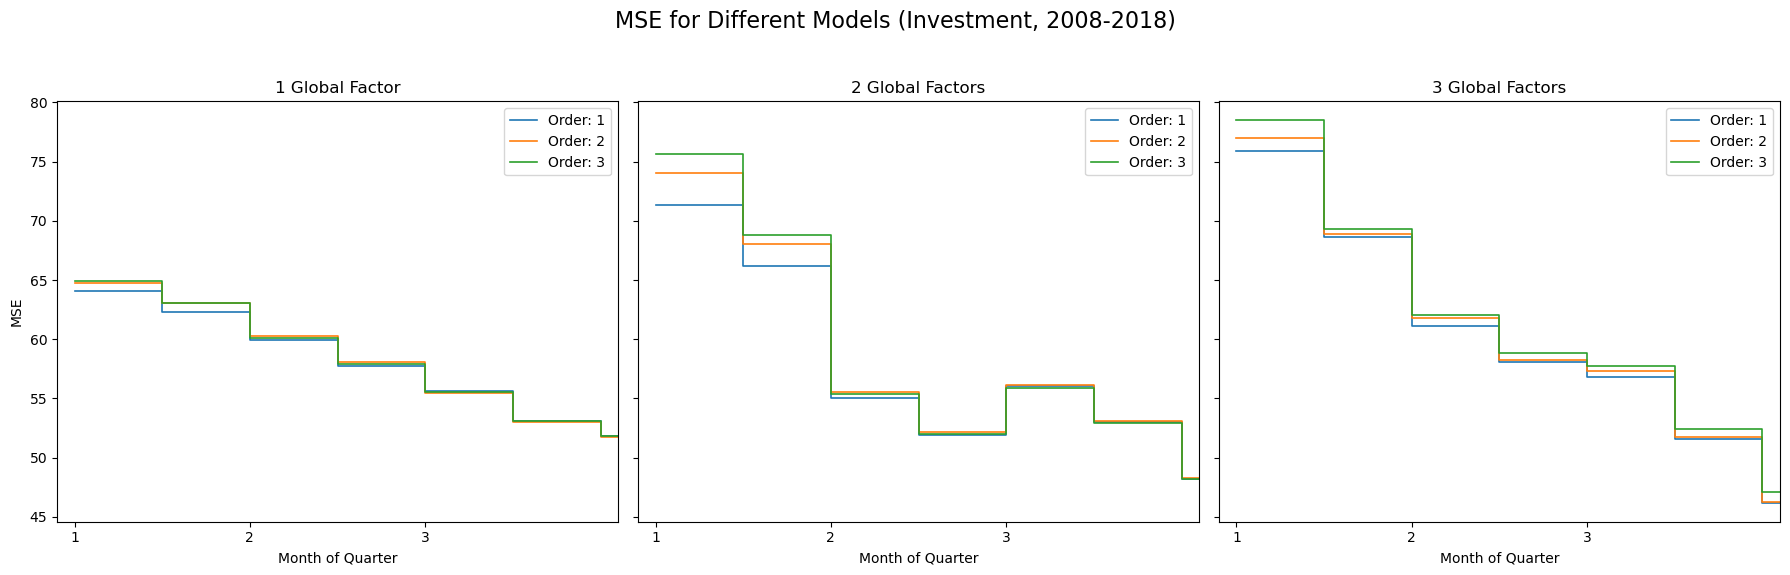

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


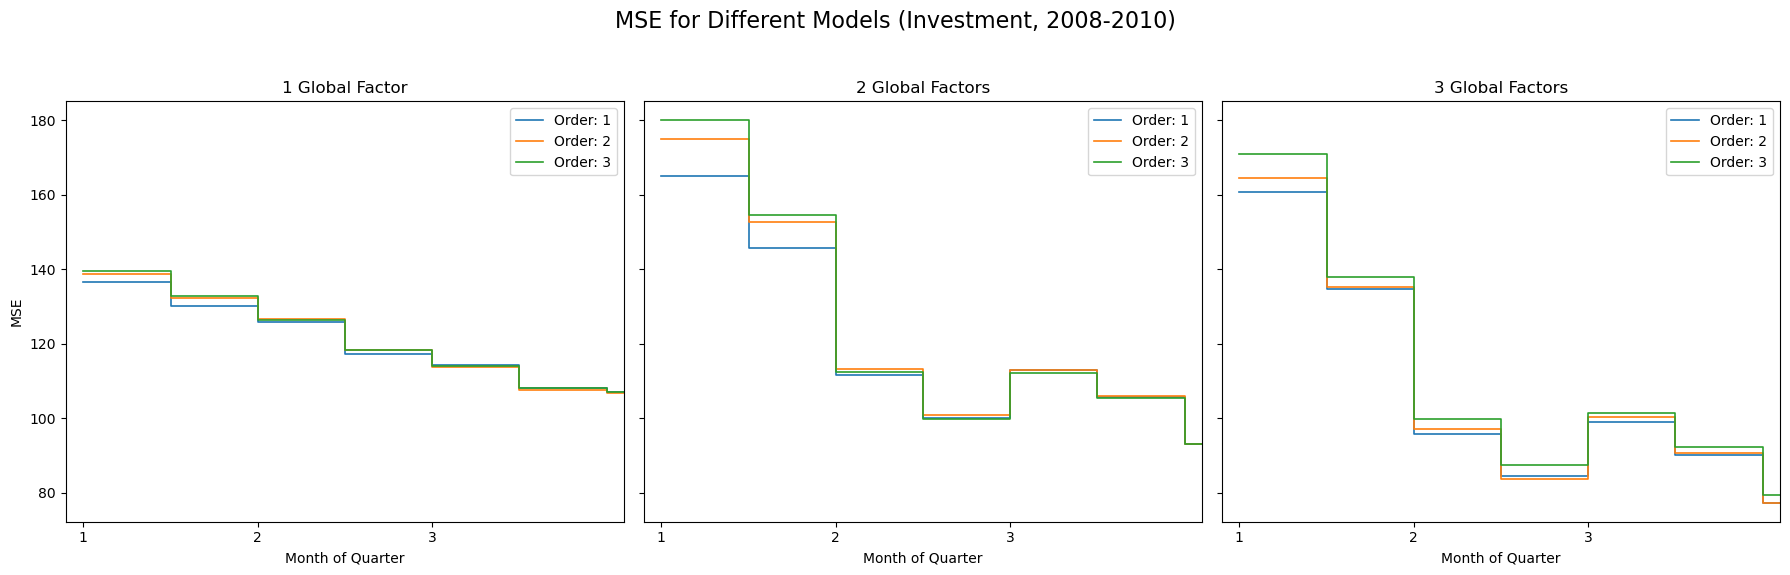

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


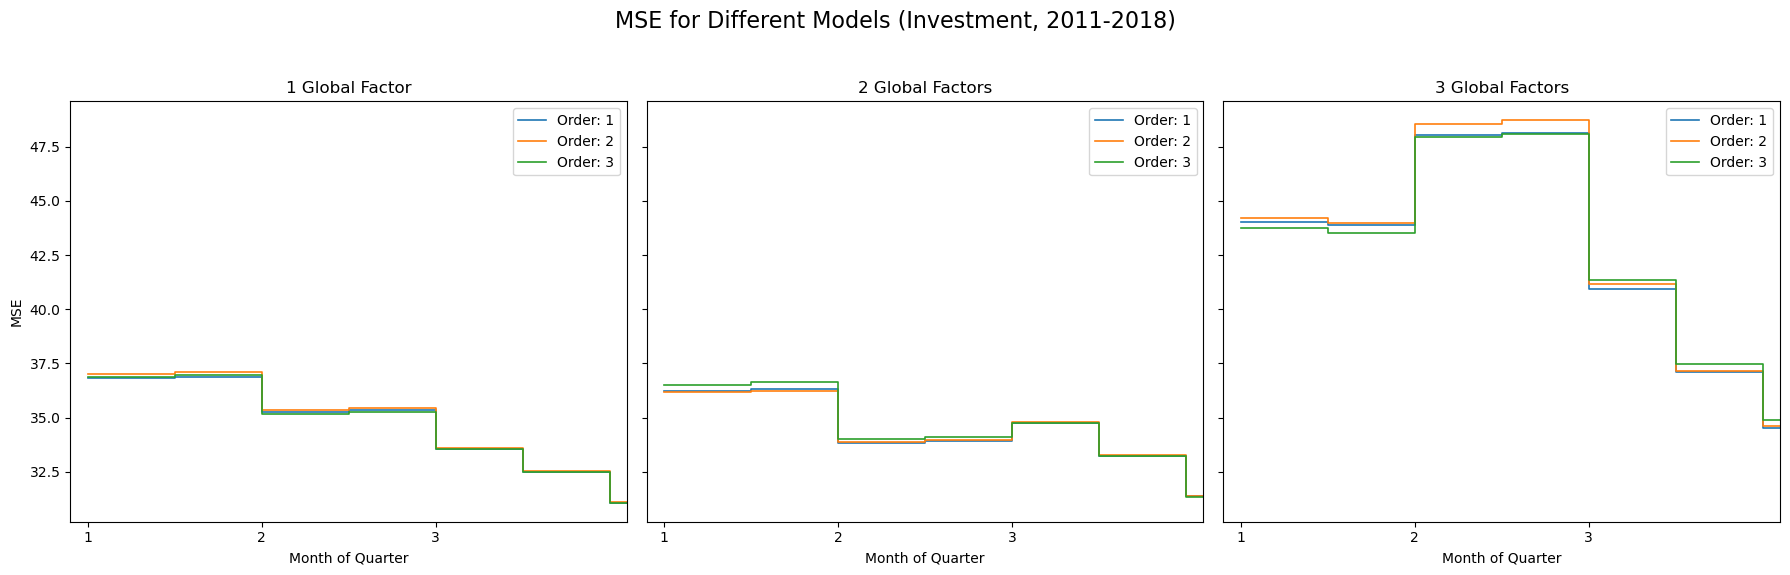

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


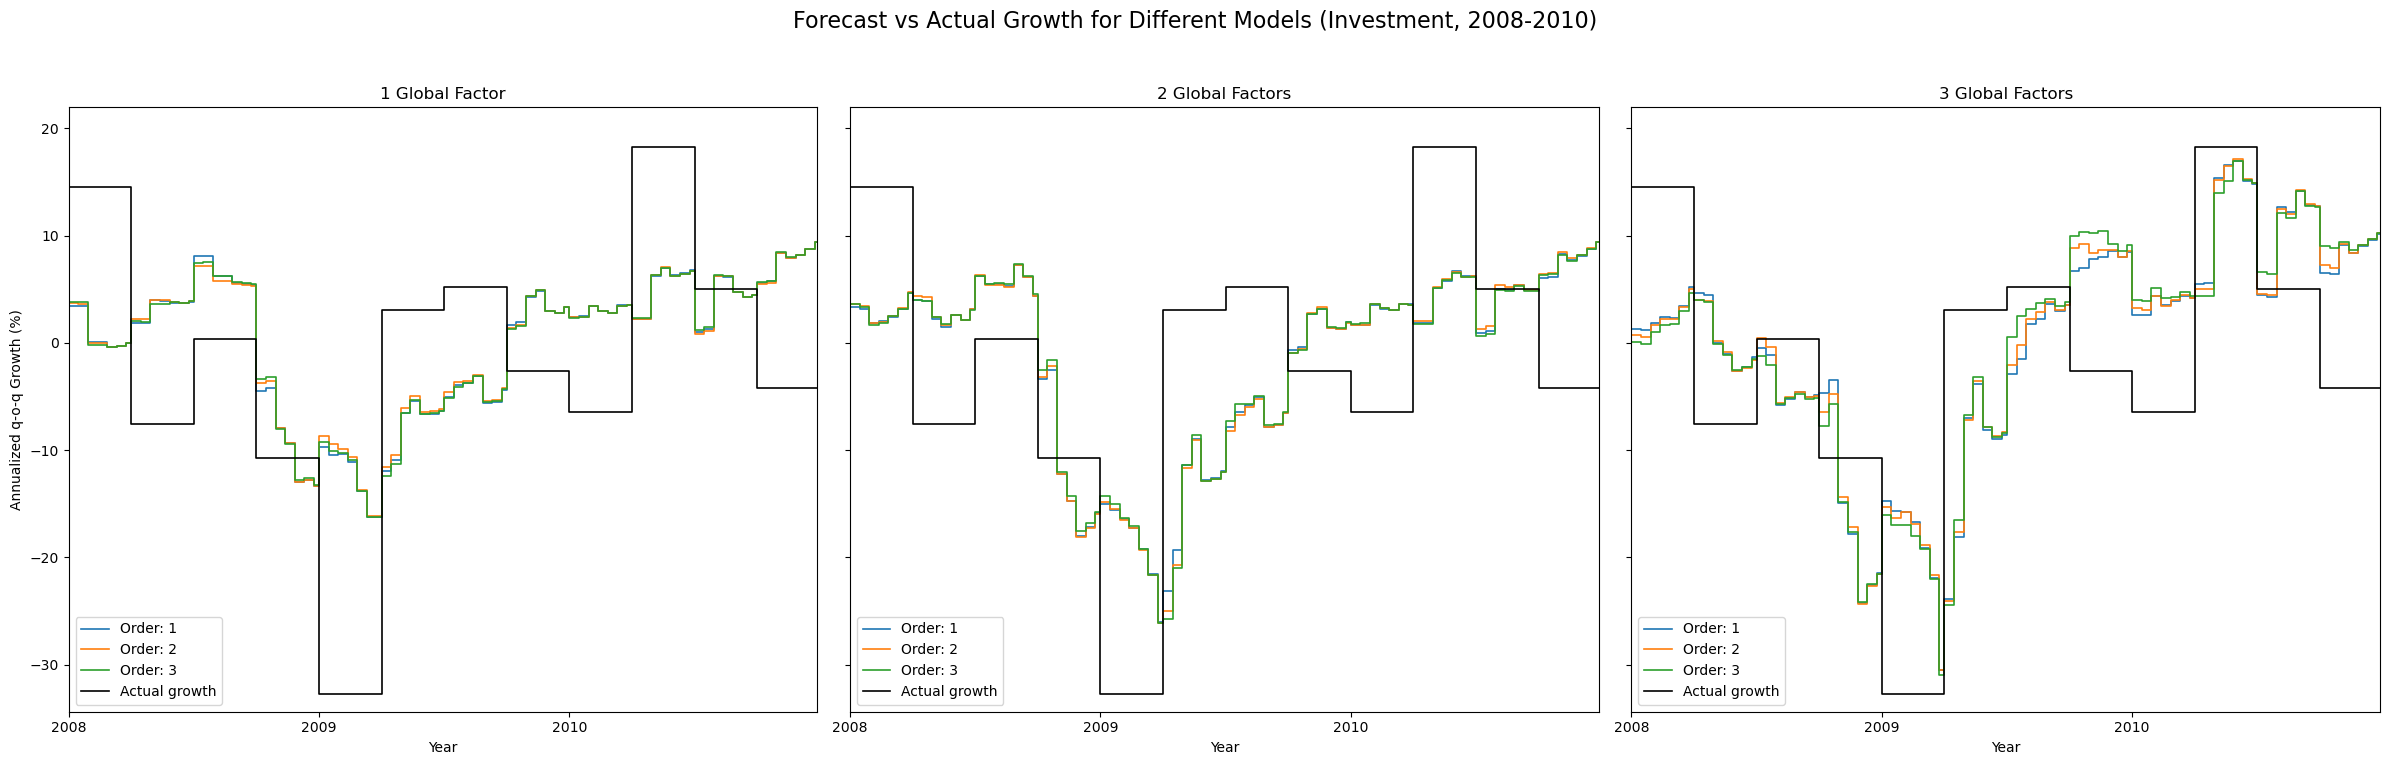

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


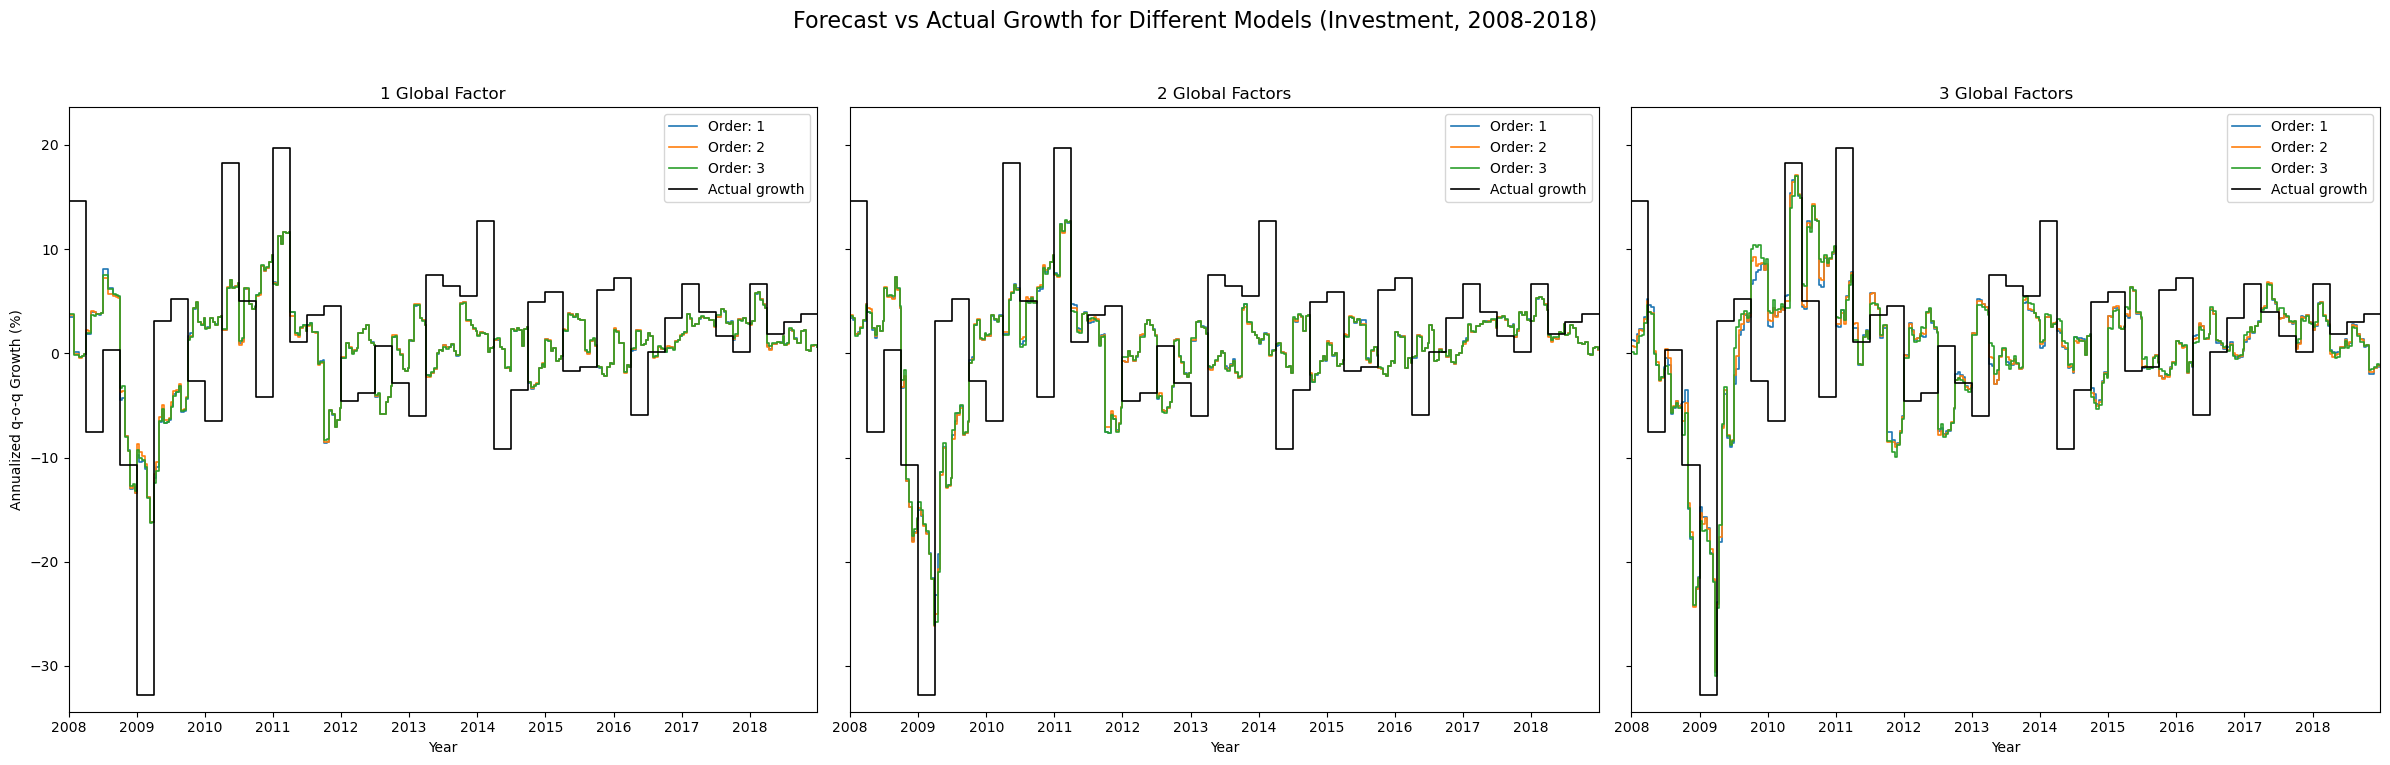

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


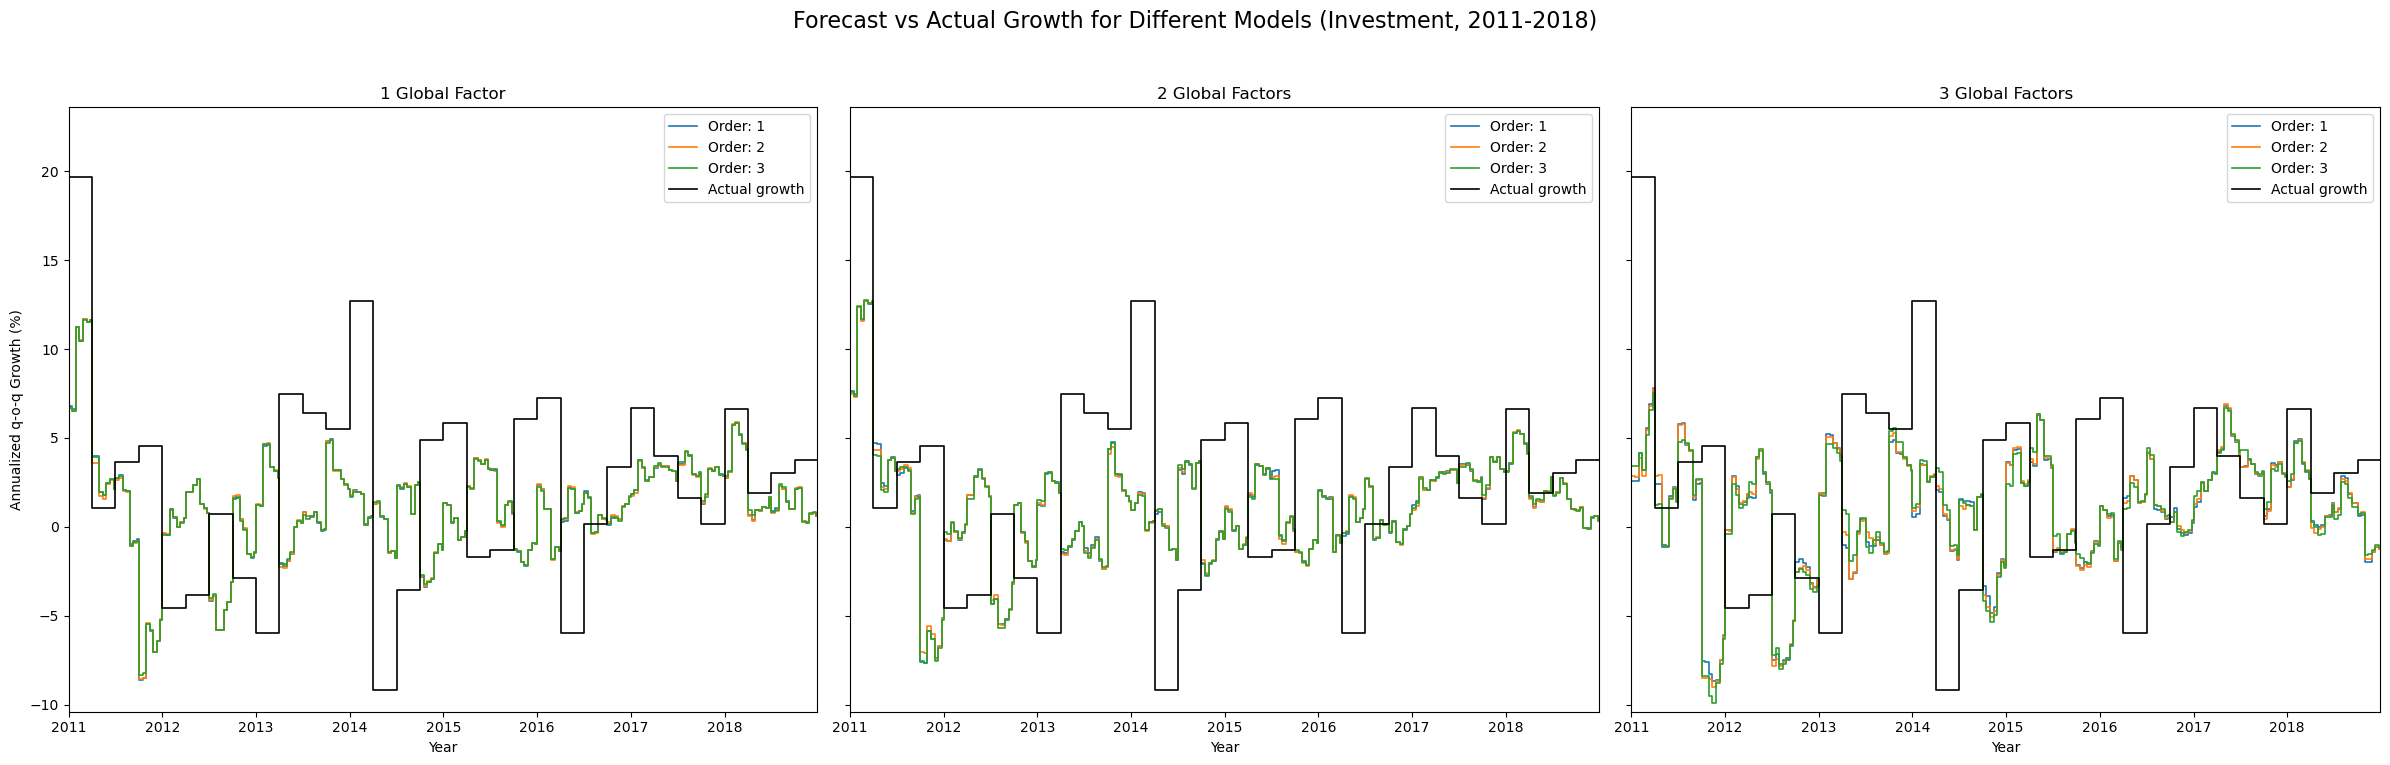

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()